<!-- Assignment ? - SS 2023 -->

# Neural Style Transfer (10 points)

This notebook contains one of the assignments for the exercises in Deep Learning and Neural Nets 2.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility functions that should work without (too much) problems.
Please, do not alter this code or add extra import statements in your submission, unless explicitly allowed!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!


In this assignment, we will take a closer at Neural Style Transfer (NST).
NST is a simple technique to apply the style of one image to scene of another image using feature representations generated by neural networks.

In [1]:
from typing import Iterable

import torch
import torchvision
from torch import nn
from torchvision.transforms import v2 as transforms
from PIL import Image

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)

In [2]:
import os.path

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _curdir = 'gdrive/MyDrive/'
except ImportError:
    _curdir = '.'
finally:
    data_root = os.path.join(_curdir, 'pytorch')

print(data_root)

Mounted at /content/gdrive
gdrive/MyDrive/pytorch


In [3]:
def download_image_data(url: str, md5: str = None, size: int = 224):
    """
    Download and pre-process some image for AlexNet.

    Parameters
    ----------
    url : str
        URL to the image.
    md5 : str, optional
        MD5 checksum of the image.
    size : int, optional
        Expected size for the image after cropping.

    Returns
    -------
    x : (1, 3, size, size) torch.Tensor
        Ready-to-predict image.
    """
    from torchvision.datasets.utils import download_url
    path = os.path.expanduser(data_root)
    download_url(url, path, md5=md5)
    file_name = url.rsplit('/', maxsplit=1)[-1]
    im = Image.open(os.path.join(path, file_name))
    # constants taken from torchvision.models docs
    normalise = transforms.Compose([
        transforms.Resize(size=(size, size), antialias=True),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((.485, .456, .406), (.229, .224, .225))
    ])
    return normalise(im).unsqueeze(0)

In [4]:
def data_to_image(*data: torch.Tensor,
                  means: tuple = (.485, .456, .406),
                  stds: tuple = (.229, .224, .225)) -> Image:
    """
    Convert multiple tensors to one big image.

    Parameters
    ----------
    data0, data1, ... dataN : torch.Tensor
        One or more tensors to be merged into a single image.
    means : tuple or torch.Tensor, optional
        Original mean of the image before normalisation.
    stds : tuple or torch.Tensor, optional
        Original standard deviation of the image before normalisation.

    Returns
    -------
    image : Image
        PIL image with all of the tensors next to each other.
    """
    # concatenate all data
    big_pic = torch.cat([x for x in data], dim=-1)

    means = torch.tensor(means)
    stds = torch.tensor(stds)
    to_image = transforms.Compose([
        # inverts normalisation of image
        transforms.Normalize(-means / stds, 1. / stds),
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
        transforms.ToPILImage()
    ])

    return to_image(big_pic)

## Neural Style Transfer

Once you have successfully trained a supervised model, you will probably be using it to classify more images.
However, it turns out that you can do much more with a trained model than just classification.
After all, deep learning is all about learning (meaningful) representations to solve complex tasks.
In this assignment, we will look at how the intermediate representations of an image classifier can be used to merge images in particular ways.
More specifically, we will look how we can transfer the "style" of an image to other images using intermediate representations in neural networks.

Consider the following two images.
The first one depicts the Hauptplatz in Linz, whereas you might recognise the second one as Starry Night, a painting by Van Gogh.
Your goal in this assignment will be to make the image of the Hauptplatz look like it has been painted by Van Gogh.

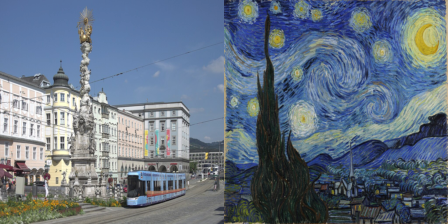

In [5]:
content_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Linz%2C_Hauptplatz.jpg/1024px-Linz%2C_Hauptplatz.jpg"
content_md5 = "4cbb0122b24d5e296bccfc0274fac48c"
content_im = download_image_data(content_url, None).cuda()
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
style_md5 = "36662857c8e933a567d9b5dfb4514503"
style_im = download_image_data(style_url, None).cuda()
data_to_image(content_im[0], style_im[0])

### Exercise 1 : Load Network (1 points)

Rather than training a network from scratch, we can save quite some time by using a pre-trained network.
You should be able to load a pre-trained network by now, but we will also need to make some modifications.
First of all, we will only need the feature-extraction part of the network.
Secondly, style transfer typically works better when we replace max-pooling layers by average pooling.
Finally, since we will only need this model for inference, we should make sure to put the model in evaluation mode.
Note that this also means that we will not need any gradients w.r.t. the weights...
When you are finished with this assignment, you should be able to explain why this might be important.

 > Implement the `load_feature_extractor` function below so that it returns a `Sequential` module representing a pre-trained feature extractor.
 > Make sure to replace any `MaxPool` layers with `AvgPool` modules to obtain good results,
 > and prepare the model for efficient inference!

In [6]:
def load_feature_extractor():
    """
    Load a pre-trained network .

    Returns
    -------
    network : torch.nn.Sequential
        The pre-trained feature extractor
    """

    network = torchvision.models.vgg19(pretrained = True)

    features = network.features

    # replace max pooling with average pooling layers
    for i, layer in enumerate(features):
        if isinstance(layer, nn.MaxPool2d):
            features[i] = nn.AvgPool2d(kernel_size=layer.kernel_size,
                                       stride=layer.stride,
                                       padding=layer.padding)

    return nn.Sequential(*features)


In [7]:
# sanity check
model = load_feature_extractor().cuda()
s = model(content_im)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 160MB/s]


### Exercise 2: Splitting the Features (2 points)

The key behind neural style transfer is to find features that represent content and/or style.
With our sequential module, it should be relatively easy to extract features from different layers in the network.
However, it is typically unnecessary to use all hidden representations in the network.
Instead, we want to be able to select subsets of features to use.
To this end, it might be useful to have a wrapper module that returns a fixed subset of features in a single forward pass.

 > Implement the `SplitNetwork` module so that it enables splitting the layers of a `Sequential` module.
 > The module is created with a list of indices for layers that produce features that we later want to use.
 > The forward pass should return the features for each index in `indices` with which the module was created.

In [35]:
class SplitNetwork(nn.Module):
    """
    A network for retrieving multiple features from a single forward pass.
    """

    def __init__(self, layers: nn.Sequential, indices: Iterable[int]):
        """
        Parameters
        ----------
        layers : torch.nn.Sequential
            A sequence of neural network layers.
        indices : Iterable of int
            Indices of the layers that produce style features.
        """
        super().__init__()
        indices = set(idx if idx >= 0 else len(layers) + idx for idx in indices)
        if any(idx < 0 or idx >= len(layers) for idx in indices):
            raise ValueError(f"Invalid indices for {len(layers)} layers: {indices}")
        self.indices = indices
        self.layers = layers

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        """
        Parameters
        ----------
        x : torch.Tensor
            Input for the network.

        Returns
        -------
        features : dict of torch.Tensor
            A dictionary mapping layer index to the extracted features.
        """
        features = {}
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i in self.indices:
                features[i] = x
        return features

In [9]:
# sanity check
style_net = SplitNetwork(model, [3, -2])
features = style_net(content_im[0])
{idx: h.shape for idx, h in features.items()}

{3: torch.Size([64, 224, 224]), 35: torch.Size([512, 14, 14])}

### Exercise 3: Harvesting Features (2 points)

Since our pre-trained classification network has been trained to classify images, hidden features can be expected to hold information about the content.
For the style features, we can use the so-called covariance matrix of the image.
For a 2d signal, e.g. a sequence, where a single sample, $\boldsymbol{X}_i$ has shape $C \times N$, the covariance matrix (of channels) can be computed as
$$\frac{1}{N} \, \boldsymbol{X}_i \cdot \boldsymbol{X}_i^\mathsf{T} \in \mathbb{R}^{C \times C}.$$
For higher-dimensional data, e.g. images, the data can be flattened to a sequence for computing the covariance matrix.

 > Implement the functions `extract_content_features` and `extract_style_features` so that they extract the necessary features for the style transfer.
 > The `prepare_content_features` is expected to extract plain hidden features to represent content.
 > The `prepare_style_features` is expected to extract covariance matrix features to represent style.

In [22]:
def cov(h: torch.Tensor) -> torch.Tensor:
    """
    Compute the covariance matrix for arbitrarily shaped data.

    Parameters
    ----------
    h : (C, K1, ...) torch.Tensor
        The sample to compute the Gram matrix for.

    Returns
    -------
    g : (C, C) torch.Tensor
        The covariance matrix of `h`.
    """

    N = h.shape[1]
    h = h.view(h.shape[0], -1)
    g = 1/N * h @ h.transpose(0, 1)
    return g

def extract_content_features(features, indices):
    """
    Parameters
    ----------
    data : torch.Tensor
        The data to extract content features from.
    network : SplitNetwork
        A network that is able to extract plain features given `data` as input.
    **kwargs
        Allows you to use custom keyword arguments (if necessary).

    Returns
    -------
    features : dict of torch.Tensor
        A dictionary mapping layer index to content features extracted from data.
    """
    indices = features.keys() if indices is None else set(indices)
    features_dict = {}
    for i in indices:
        if i in features:
            features_dict[i] = features[i]
    return features_dict


def extract_style_features(features, indices):
    """
    Parameters
    ----------
    content : torch.Tensor
        The style data to extract features from.
    network : SplitNetwork
        A network that is able to extract plain features given `data` as input.
    **kwargs
        Allows you to use custom keyword arguments (if necessary).

    Returns
    -------
    features : dict of torch.Tensor
        A dictionary mapping layer index to style features extracted from data.
    """
    indices = features.keys() if indices is None else set(indices)
    features_dict = {}
    for i in indices:
        if i in features:
            features_dict[i] = features[i]
    return features_dict

In [23]:
# sanity check
print(cov(next(iter(features.values()))).shape)
content_features = extract_content_features(style_net(content_im[0]), indices=None)
print({idx: x.shape for idx, x in content_features.items()})
style_features = extract_style_features(style_net(style_im[0]), indices=None)
print({idx: x.shape for idx, x in style_features.items()})

torch.Size([64, 64])
{3: torch.Size([64, 224, 224]), 35: torch.Size([512, 14, 14])}
{3: torch.Size([64, 224, 224]), 35: torch.Size([512, 14, 14])}


### Exercise 4: Neural Style Transfer Loss (2 points)

With the function from exercise 3, you can extract content features and style features of some reference images.
Now, the only thing left to do is to create an image with style and content features that match the corresponding features of our reference style and content images, respectively.
This turns out to be an optimisation problem that can be formulated as follows:
$$\arg\min_\boldsymbol{x} \Big(\frac{1}{K_\mathrm{c}} \sum_{i=1}^{K_\mathrm{c}} L_\mathrm{content}\bigl(f_i(\boldsymbol{x}_\mathrm{c}), f_i(\boldsymbol{x})\bigr) + \frac{1}{K_\mathrm{s}}\sum_{i=1}^{K_\mathrm{s}}L_\mathrm{style}\bigl(f_i(\boldsymbol{x}_\mathrm{s}), f_i(\boldsymbol{x})\bigr)\Big),$$
where $f_i$ is a mapping from the input to one of $K$ hidden representations and $\boldsymbol{x}_\mathrm{c}$ and $\boldsymbol{x}_\mathrm{s}$ are the reference content and style images, respectively.
Because the features are typically continuous, a typical loss to use in this case is the mean squared error.
Note that $\boldsymbol{x}_\mathrm{c}$ and $\boldsymbol{x}_\mathrm{s}$ do not change, so it is typically not necessary to recompute these values.

 > Implement the `neural_style_loss` function so that it can be used for solving the Neural Style Transfer optimisation problem.
 > It should return the loss values for the content and style separately to allow reweighting of the loss components.

In [24]:
def neural_style_loss(
    x: torch.Tensor,
    network: SplitNetwork,
    style_features: dict[int, torch.Tensor],
    content_features: dict[int, torch.Tensor],
    loss_func=nn.MSELoss()
):
    """
    Loss function for Neural Style Transfer.

    Parameters
    ----------
    x : torch.Tensor
        The data to compute the loss for.
    network : SplitNetwork
        A network that is able to extract plain features given `x` as input.
    style_features : dict mapping int to torch.Tensor
        Reference style features.
    content_features : dict mapping int to torch.Tensor
        Reference content features.
    loss_func : optional
        The loss function to use for the Neural Style Transfer.

    Returns
    -------
    style_loss : torch.Tensor
        The style component of the loss.
    content_loss : torch.Tensor
        The content component of the loss.
    """
    # extract features for input
    features = network(x)

    # compute style loss
    style_loss = 0
    for i, t in style_features.items():
        if i in style_features:
            g = cov(features[i])
            t = cov(t)
            style_loss += loss_func(g, t)

    # compute content loss
    content_loss = 0
    for i, t in content_features.items():
        if i in content_features:
            content_loss += loss_func(features[i], t)

    return style_loss, content_loss

In [25]:
# sanity check
x = torch.zeros_like(content_im[0])
neural_style_loss(x, style_net, style_features, content_features)

(tensor(16910.3926, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.5529, device='cuda:0', grad_fn=<AddBackward0>))

### Exercise 5: Transfer (3 points)

Now that we have all components for the Neural Style Transfer, we can actually solve the optimisation problem.
As you might have expected, we can (and will) use a gradient-based method to optimise an image to get the desired result.
However, to get the desired result, it can be important to correctly weight the style and content loss.
Therefore, we typically introduce a parameter $\beta$ so that the objective becomes $L_\mathrm{style} + \beta \, L_\mathrm{content}$.
With this final bit of information you should be in a position to finish the neural style transfer.
Remaining open questions, e.g. where to start the optimisation, should provide you with some food for thought.

 > Implement the `neural_style_transfer` method so that it produces an image with the content of one image and the style of another image.

In [39]:
from tqdm import tqdm

def neural_style_transfer(
    x_content: torch.Tensor,
    x_style: torch.Tensor,
    layers: nn.Sequential,
    style_indices: Iterable[int],
    content_indices: Iterable[int],
    num_steps: int = 100,
    learning_rate: float = 1e-1,
    beta: float = 0 #1e-4
):
    """
    Parameters
    ----------
    x_content : torch.Tensor
        The content image.
    x_style : torch.Tensor
        The style image.
    layers : torch.nn.Sequential
        A sequence of neural network layers.
    style_indices : Iterable of int
        Indices of the layers that produce style features.
    content_indices : Iterable of int
        Indices of the layers that produce content features.
    num_steps : int
        Number of steps to perform.
    learning_rate : float
        Learning rate for the optimizer.
    beta : float
        Weight of the content loss.

    Returns
    -------
    x : torch.Tensor
        The stylised image.
    """

    x = x_content.clone().requires_grad_(True)
    net = SplitNetwork(layers, style_indices + content_indices).cuda()
    optim = torch.optim.AdamW([x], lr=learning_rate, weight_decay=0.1)

    style_features = extract_style_features(net(x_style), style_indices)
    content_features = extract_content_features(net(x_content), content_indices)

    for step in tqdm(range(num_steps)):
        optim.zero_grad()
        style_loss, content_loss = neural_style_loss(x, net, style_features, content_features)
        tot_loss = style_loss + beta * content_loss
        tot_loss.backward(retain_graph = True)
        optim.step()

        if step % 10 == 0:
            print(f"Step {step}: Style loss: {style_loss.item():.4f}, Content loss: {content_loss.item():.4f}")

    return x


  6%|▌         | 6/100 [00:00<00:04, 21.65it/s]

Step 0: Style loss: 6323.8896, Content loss: 0.0000


 16%|█▌        | 16/100 [00:00<00:03, 25.69it/s]

Step 10: Style loss: 577.8486, Content loss: 3.1672


 26%|██▌       | 26/100 [00:01<00:02, 26.73it/s]

Step 20: Style loss: 328.5686, Content loss: 4.0847


 36%|███▌      | 36/100 [00:01<00:02, 26.75it/s]

Step 30: Style loss: 197.6182, Content loss: 4.5219


 46%|████▌     | 46/100 [00:01<00:02, 26.95it/s]

Step 40: Style loss: 126.8357, Content loss: 4.7400


 56%|█████▌    | 56/100 [00:02<00:01, 26.98it/s]

Step 50: Style loss: 91.2266, Content loss: 4.8855


 66%|██████▌   | 66/100 [00:02<00:01, 27.02it/s]

Step 60: Style loss: 71.5991, Content loss: 4.9645


 76%|███████▌  | 76/100 [00:03<00:00, 26.97it/s]

Step 70: Style loss: 59.5821, Content loss: 5.0234


 87%|████████▋ | 87/100 [00:03<00:00, 26.94it/s]

Step 80: Style loss: 51.6634, Content loss: 5.0841


 97%|█████████▋| 97/100 [00:03<00:00, 26.31it/s]

Step 90: Style loss: 45.9804, Content loss: 5.1374


100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


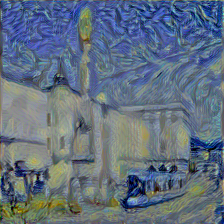

In [40]:
# sanity check
res = neural_style_transfer(content_im[0], style_im[0], model, style_indices=[3, 6, 8, 11], content_indices=[16, 18])
data_to_image(res)

  2%|▏         | 2/100 [00:00<00:09, 10.17it/s]

Step 0: Style loss: 4400.8149, Content loss: 0.0000


 14%|█▍        | 14/100 [00:00<00:04, 17.50it/s]

Step 10: Style loss: 530.7526, Content loss: 0.2240


 23%|██▎       | 23/100 [00:01<00:03, 19.26it/s]

Step 20: Style loss: 247.5229, Content loss: 0.2693


 35%|███▌      | 35/100 [00:01<00:03, 18.89it/s]

Step 30: Style loss: 142.9293, Content loss: 0.2985


 45%|████▌     | 45/100 [00:02<00:02, 19.12it/s]

Step 40: Style loss: 87.3221, Content loss: 0.3165


 55%|█████▌    | 55/100 [00:03<00:02, 19.07it/s]

Step 50: Style loss: 60.2855, Content loss: 0.3271


 65%|██████▌   | 65/100 [00:03<00:01, 19.14it/s]

Step 60: Style loss: 44.7664, Content loss: 0.3353


 75%|███████▌  | 75/100 [00:04<00:01, 19.20it/s]

Step 70: Style loss: 35.1897, Content loss: 0.3402


 85%|████████▌ | 85/100 [00:04<00:00, 19.09it/s]

Step 80: Style loss: 28.7994, Content loss: 0.3428


 95%|█████████▌| 95/100 [00:05<00:00, 19.06it/s]

Step 90: Style loss: 24.2259, Content loss: 0.3449


100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


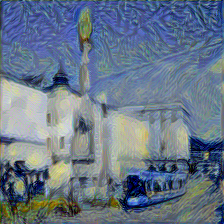

In [36]:
# sanity check
res = neural_style_transfer(content_im[0], style_im[0], model, style_indices=[2, 5, 10], content_indices=[30, 32, 34])
data_to_image(res)